# 02_data_preparation.ipynb

In [3]:
# Data Preparation and Loading
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [4]:
# Dataset path
DATASET_DIR = "../data/raw/EuroSAT_RGB"
OUTPUT_DIR = "../data/processed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
# Check dataset
class_dirs = [d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))]
print(f"Found {len(class_dirs)} classes: {', '.join(class_dirs)}")

Found 10 classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake


In [6]:
# Create class to index mapping
class_to_idx = {class_name: i for i, class_name in enumerate(sorted(class_dirs))}
idx_to_class = {i: class_name for class_name, i in class_to_idx.items()}

In [7]:
# Save mappings for later use
import json
with open(os.path.join(OUTPUT_DIR, "class_mappings.json"), "w") as f:
    json.dump({"class_to_idx": class_to_idx, "idx_to_class": idx_to_class}, f)

In [8]:
# Create custom Dataset
class EuroSATDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        
        # Load all image paths and labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.jpg'):
                    self.images.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [9]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),                                              # Convert PIL image to PyTorch tensor (and scale to [0,1])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [12]:
# Create full dataset with transformations
full_dataset = EuroSATDataset(DATASET_DIR, transform=None)  # No transform for initial split

In [13]:
# Split dataset into train, validation, and test sets
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - (train_size + val_size)

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], 
    generator=torch.Generator().manual_seed(42)
)

In [14]:
# Apply transformations after splitting
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.subset)

train_dataset = TransformedSubset(train_dataset, train_transform)
val_dataset = TransformedSubset(val_dataset, val_transform)
test_dataset = TransformedSubset(test_dataset, val_transform)

In [54]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) # set to 0 while troubleshooting show_batch() getting hung
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [61]:
# Display dataset stats
print(f"Total images: {total_size}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Test images: {len(test_dataset)}")

Total images: 27000
Training images: 18900
Validation images: 4050
Test images: 4050


In [63]:
# # Check if full_dataset object was created properly
# print(f"Number of images found: {len(full_dataset)}")
# print(f"First few image paths: {full_dataset.images[:3]}")

Number of images found: 27000
First few image paths: ['../data/raw/EuroSAT_RGB\\AnnualCrop\\AnnualCrop_1.jpg', '../data/raw/EuroSAT_RGB\\AnnualCrop\\AnnualCrop_10.jpg', '../data/raw/EuroSAT_RGB\\AnnualCrop\\AnnualCrop_100.jpg']


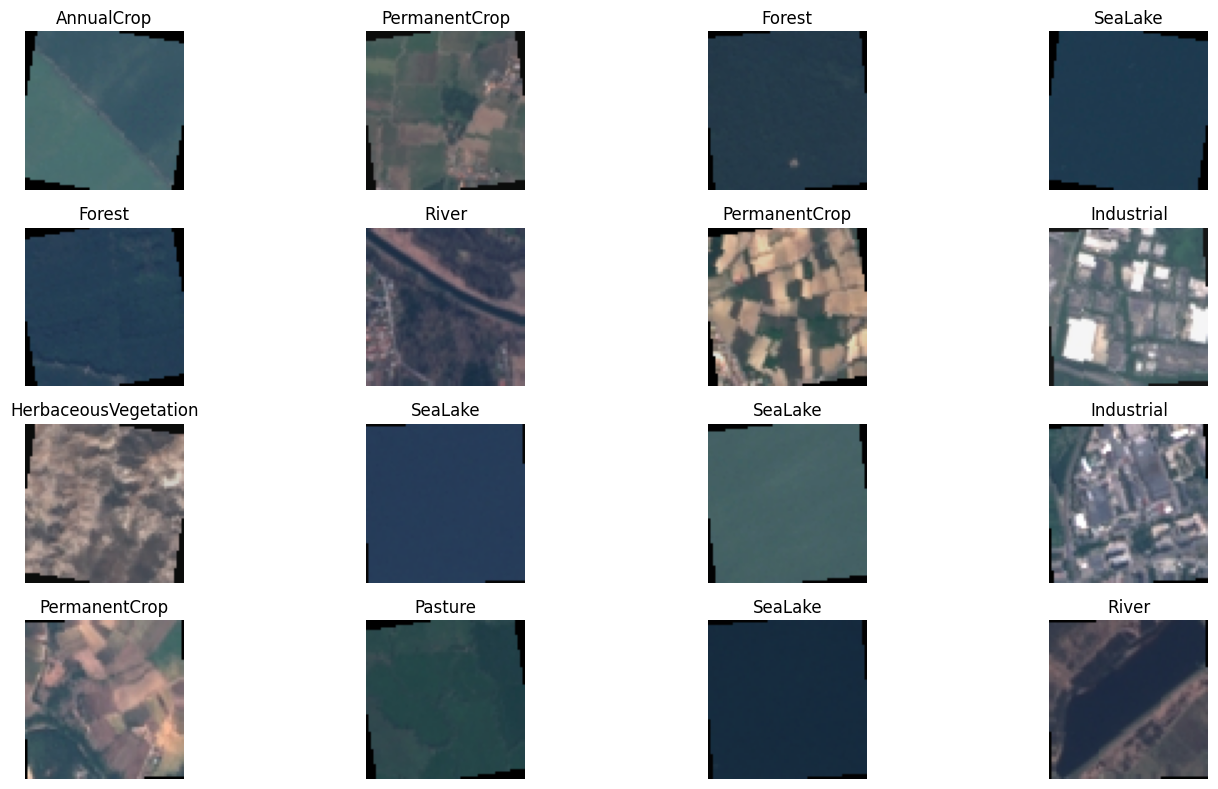

In [64]:
# Visualize some samples from training set
def show_batch(dataloader):
    images, labels = next(iter(dataloader))
    
    # Convert tensors back from normalized form for visualization
    images = images.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    
    plt.figure(figsize=(15, 8))
    for i in range(min(16, len(images))):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.title(idx_to_class[labels[i].item()])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show a batch of training images
show_batch(train_loader)

In [65]:
# Save the data loaders
torch.save({
    'train_indices': train_dataset.subset.indices,
    'val_indices': val_dataset.subset.indices,
    'test_indices': test_dataset.subset.indices,
}, os.path.join(OUTPUT_DIR, 'dataset_splits.pt'))

print("Data preparation complete!")

Data preparation complete!
